# Diagrama de Sankey
---

En esta celda, vamos a utilizar los datos de esta primera iteración del modelado para analizar como se dividió todo el flujo de estudiantes del curso entre la entrega de tareas de evaluación continua del curso y respecto a las notas que obtuvieron

## Diagrama de entregas


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Assuming DATA_PATH and df_entregas setup from your original code
DATA_PATH = "/home/carlos/Documentos/TFG/spark-workspace/data/datasets"
df_entregas = pd.read_parquet(f"{DATA_PATH}/dataset_1.1.parquet")

df_entregas = df_entregas.drop(columns=["num_entregas"])

columns_entregas = df_entregas.columns.tolist()
columns_entregas.remove("Test Complejidad")
columns_entregas.insert(-2, "Test Complejidad")
df_entregas = df_entregas[columns_entregas]

columns_entregas.remove("abandona")
columns_entregas.append("abandona")
df_entregas = df_entregas[columns_entregas]

# ─────────────────── FUNCIONES ────────────────────
def build_sankey_entregas_abandono(df):
    """
    Crea nodos, enlaces y colores para:
      actividades 0/1  →  'abandona' (0 = Sigue, 1 = Abandona)
    """
    # Excluye 'userid' y 'abandona' de las columnas de actividad iniciales
    activity_cols = [c for c in df.columns if c not in {"userid", "abandona"}]
    
    node_idx, labels = {}, []
    source, target, value, link_colors = [], [], [], []
    
    # helper: traduce valor a etiqueta según la columna
    def label(col, val):
        if col == "abandona":
            return "Abandona" if val == 1 else "Sigue"
        return "Entregó" if val == 1 else "No entregó"
    
    # Define colores para los enlaces
    color_abandona = "rgba(255, 0, 0, 0.4)"  # Rojo para abandono
    color_sigue = "rgba(0, 128, 0, 0.4)"     # Verde para continuar
    
    # 1) registrar nodos para las actividades
    for col in activity_cols:
        for val in (1, 0): # 1 primero para que quede arriba
            node_idx[(col, val)] = len(labels)
            labels.append(f"{col}<br>{label(col,val)}")
            
    # 1.1) registrar nodos para el estado final de abandono
    # Estos nodos deben aparecer al final del diagrama.
    # Necesitamos asegurar que sus índices sean únicos y secuenciales después de las actividades.
    # Las etiquetas "Sigue" y "Abandona" se añadirán una vez al final.
    node_idx[("abandona", 0)] = len(labels) # Sigue
    labels.append("Sigue")
    node_idx[("abandona", 1)] = len(labels) # Abandona
    labels.append("Abandona")

    # 2) contar transiciones entre columnas consecutivas de actividades
    for col1, col2 in zip(activity_cols[:-1], activity_cols[1:]):
        counts = (
            df.groupby([col1, col2, "abandona"]).size().reset_index(name="n")
        )
        for _, row in counts.iterrows():
            v1, v2, abandona_status, n = int(row[col1]), int(row[col2]), int(row["abandona"]), int(row["n"])
            
            source.append(node_idx[(col1, v1)])
            target.append(node_idx[(col2, v2)])
            value.append(n)
            
            if abandona_status == 1:
                link_colors.append(color_abandona)
            else:
                link_colors.append(color_sigue)

    # 3) Contar transiciones de la última actividad al estado final (abandona/sigue)
    last_activity_col = activity_cols[-1]
    counts_to_final = (
        df.groupby([last_activity_col, "abandona"]).size().reset_index(name="n")
    )
    for _, row in counts_to_final.iterrows():
        v_last_act, abandona_status, n = int(row[last_activity_col]), int(row["abandona"]), int(row["n"])
        
        source.append(node_idx[(last_activity_col, v_last_act)])
        target.append(node_idx[("abandona", abandona_status)]) # Conecta con el nodo 'Abandona' o 'Sigue'
        value.append(n)
        
        if abandona_status == 1:
            link_colors.append(color_abandona)
        else:
            link_colors.append(color_sigue)
    
    return labels, source, target, value, link_colors

def plot_sankey(labels, source, target, value, link_colors, title):
    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(label=labels, pad=15, thickness=16,
                  color="rgba(44,160,101,0.8)"), # El color del nodo puede ser genérico o personalizado
        link=dict(source=source, target=target, value=value,
                  color=link_colors) # Usar los colores de los enlaces generados dinámicamente
    ))
    fig.update_layout(title_text=title, font_size=12, height=600)
    fig.show()

# ─────────────────── EJECUCIÓN ────────────────────
labels, src, tgt, val, link_colors = build_sankey_entregas_abandono(df_entregas)

plot_sankey(labels, src, tgt, val, link_colors,
            "Flujo de ENTREGAS por actividad ➜ Estado final (Abandona / Sigue)")

## Consultas exploratorias

In [3]:
display(df_entregas.head())  # Mostrar las primeras filas del DataFrame para referencia

all_activities = columns_entregas[1:-1]  # Exclude 'userid' and 'abandona'
all_delivered_and_abandoned = df_entregas[(df_entregas[all_activities] == 1).all(axis=1) & (df_entregas['abandona'] == 1)]
print(f"Cantidad de alumnos que entregaron todas las actividades y luego abandonaron: {len(all_delivered_and_abandoned)}")

none_delivered_and_abandoned = df_entregas[(df_entregas[all_activities] == 0).all(axis=1) & (df_entregas['abandona'] == 1)]
print(f"Cantidad de alumnos que no entregaron ninguna actividad y luego abandonaron: {len(none_delivered_and_abandoned)}")

not_all_delivered_and_abandoned = df_entregas[(df_entregas[all_activities] != 1).any(axis=1) & (df_entregas['abandona'] == 1)]
print(f"Cantidad de alumnos que no hicieron todas las entregas y luego abandonaron: {len(not_all_delivered_and_abandoned)}")

not_all_delivered_and_not_abandoned = df_entregas[(df_entregas[all_activities] != 1).any(axis=1) & (df_entregas['abandona'] == 0)]
print(f"Cantidad de alumnos que no hicieron todas las entregas pero aun así no abandonaron: {len(not_all_delivered_and_not_abandoned)}")


,userid,Test Expr.,Act. 02 - Elecciones,Act. 03 - Catalan,Act. 04 - Primos,Act. 05 - Vectores,Test Complejidad,Act. 07,abandona
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,1,1,1,1,0,1,1,0
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,1,1,1,1,1,1,1,0
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,1,1,1,1,1,1,1,1
3,b6b2a12e84ea8203775195ed2bb4e99c5788053782b0bd...,1,1,1,1,1,1,1,0
4,fd96e32a94a932f45eb32933d9ffeb71f4addf9153a76b...,1,1,1,0,1,1,1,0


Cantidad de alumnos que entregaron todas las actividades y luego abandonaron: 4
Cantidad de alumnos que no entregaron ninguna actividad y luego abandonaron: 5
Cantidad de alumnos que no hicieron todas las entregas y luego abandonaron: 29
Cantidad de alumnos que no hicieron todas las entregas pero aun así no abandonaron: 54


Cantidad de alumnos que entregaron todas las actividades y luego abandonaron: 4
Cantidad de alumnos que no entregaron ninguna actividad y luego abandonaron: 5
Cantidad de alumnos que fallaron en alguna entrega y luego abandonaron: 24
Cantidad de alumnos que no hicieron alguna entrega y abandonaron (calculado): 29
Cantidad de alumnos que no hicieron alguna entrega pero aun así no abandonaron: 54


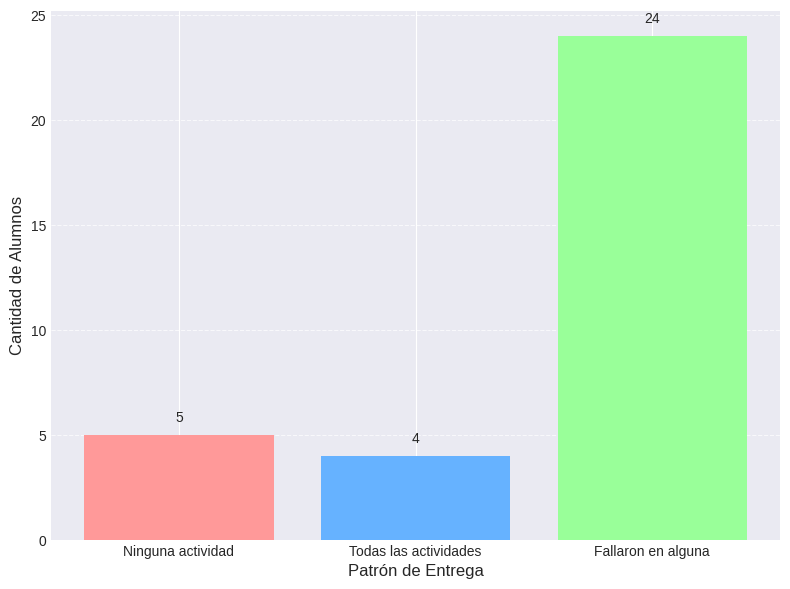

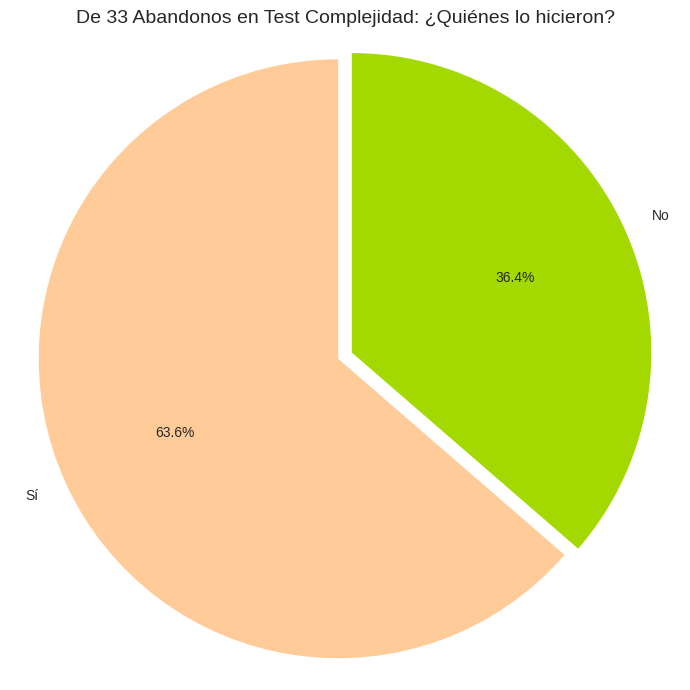

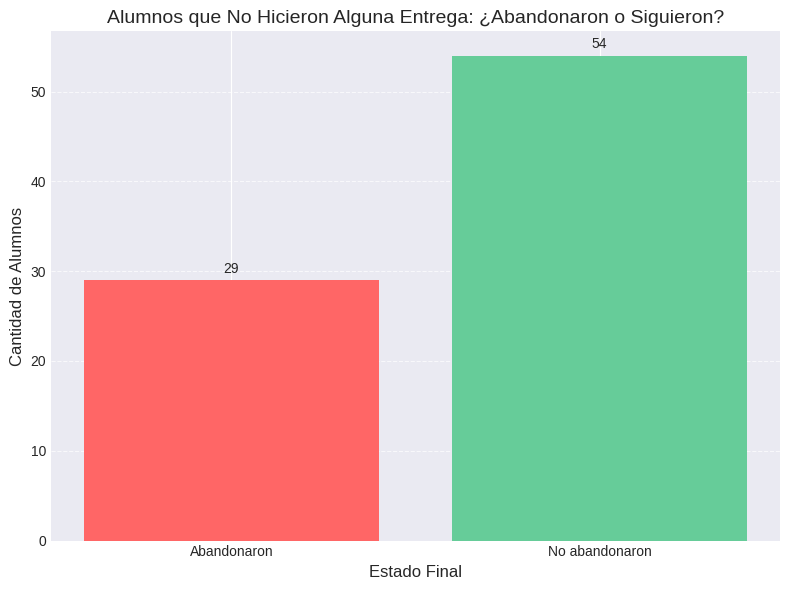

In [5]:
# --- CÁLCULOS QUE YA TIENES (PARA VERIFICAR LA REPRODUCCIÓN) ---

# 1. Alumnos que entregaron todas las actividades y luego abandonaron
all_delivered_and_abandoned = df_entregas[(df_entregas[all_activities] == 1).all(axis=1) & (df_entregas['abandona'] == 1)]
count_all_delivered_and_abandoned = len(all_delivered_and_abandoned)
# En base a tus datos, este debería ser 4
print(f"Cantidad de alumnos que entregaron todas las actividades y luego abandonaron: {count_all_delivered_and_abandoned}")

# 2. Alumnos que no entregaron ninguna actividad y luego abandonaron
none_delivered_and_abandoned = df_entregas[(df_entregas[all_activities] == 0).all(axis=1) & (df_entregas['abandona'] == 1)]
count_none_delivered_and_abandoned = len(none_delivered_and_abandoned)
# En base a tus datos, este debería ser 5
print(f"Cantidad de alumnos que no entregaron ninguna actividad y luego abandonaron: {count_none_delivered_and_abandoned}")

# 3. Alumnos que no hicieron todas las entregas y luego abandonaron (y que no están en 'ninguna')
# Esto es 'fallaron en alguna' + 'no hicieron ninguna'
# Pero tus datos dicen 'fallaron en alguna' para el "resto" después de 5 y 4.
# Total abandonaron = 5 (ninguna) + 4 (todas) + X (fallaron alguna)
# Si X = total abandonos - 9. Necesitamos saber el total de abandonos primero.
total_abandoned = df_entregas['abandona'].sum()
count_failed_some_and_abandoned = total_abandoned - count_all_delivered_and_abandoned - count_none_delivered_and_abandoned
print(f"Cantidad de alumnos que fallaron en alguna entrega y luego abandonaron: {count_failed_some_and_abandoned}")


# 4. Alumnos que no hicieron alguna entrega (es decir, (df_entregas[all_activities] != 1).any(axis=1))
# Este es el grupo que incluye 'fallaron en alguna' Y 'no hicieron ninguna'
not_all_delivered = df_entregas[(df_entregas[all_activities] == 0).any(axis=1)]

not_all_delivered_and_abandoned_calculated = len(df_entregas[(df_entregas[all_activities] == 0).any(axis=1) & (df_entregas['abandona'] == 1)])
print(f"Cantidad de alumnos que no hicieron alguna entrega y abandonaron (calculado): {not_all_delivered_and_abandoned_calculated}")

not_all_delivered_and_not_abandoned = df_entregas[(df_entregas[all_activities] == 0).any(axis=1) & (df_entregas['abandona'] == 0)]
count_not_all_delivered_and_not_abandoned = len(not_all_delivered_and_not_abandoned)
print(f"Cantidad de alumnos que no hicieron alguna entrega pero aun así no abandonaron: {count_not_all_delivered_and_not_abandoned}")


# --- PREPARACIÓN DE DATOS PARA LOS GRÁFICOS BASADO EN TUS NÚMEROS DADOS ---

# 1. Alumnos que abandonaron y su patrón de entrega
data_abandoned_pattern = {
    'Patrón de Entrega': ['Ninguna actividad', 'Todas las actividades', 'Fallaron en alguna'],
    'Cantidad de Alumnos': [5, 4, total_abandoned - 9] # total_abandoned debe ser calculado desde tus datos reales
}
df_abandoned_pattern = pd.DataFrame(data_abandoned_pattern)
# Ajustar para que 'total_abandoned - 9' sea el "resto" de los que abandonaron
# Si los 5+4 = 9 abandonaron, el resto de los abandonos es 33 (del punto 2) - 9 = 24?
# Vamos a asumir que el total de abandonos para el punto 1 es el mismo que para el punto 2 (33)
# O simplemente usar los números que nos das para el punto 1
# Si 5 no hicieron ninguna, 4 hicieron todas, y el resto fallaron en alguna
# Implica que el "resto" es el total de abandonos menos 9.
# Vamos a usar el número de 33 abandonos del punto 2 para ser consistentes con el "total_abandoned".
# El "resto" sería 33 - 5 - 4 = 24
total_abandoned_from_point2 = 33
data_abandoned_pattern['Cantidad de Alumnos'][2] = total_abandoned_from_point2 - data_abandoned_pattern['Cantidad de Alumnos'][0] - data_abandoned_pattern['Cantidad de Alumnos'][1]


# 2. Alumnos que abandonaron el test de complejidad
data_test_complejidad = {
    'Hizo Test de Complejidad': ['Sí', 'No'],
    'Cantidad de Alumnos': [21, 12]
}
df_test_complejidad = pd.DataFrame(data_test_complejidad)

# 3. Alumnos que no hicieron alguna entrega y su estado final
data_no_all_delivered_status = {
    'Estado Final': ['Abandonaron', 'No abandonaron'],
    'Cantidad de Alumnos': [29, 54]
}
df_no_all_delivered_status = pd.DataFrame(data_no_all_delivered_status)


# --- GENERACIÓN DE LOS DIAGRAMAS ---

plt.style.use('seaborn-v0_8-darkgrid') # Estilo más estético

# Diagrama 1: Patrón de entrega de alumnos que abandonaron
plt.figure(figsize=(8, 6))
plt.bar(df_abandoned_pattern['Patrón de Entrega'], df_abandoned_pattern['Cantidad de Alumnos'], color=['#FF9999', '#66B2FF', '#99FF99'])
plt.xlabel('Patrón de Entrega', fontsize=12)
plt.ylabel('Cantidad de Alumnos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, val in enumerate(df_abandoned_pattern['Cantidad de Alumnos']):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


# Diagrama 2: Alumnos que abandonaron el test de complejidad (Contraintuitivo)
plt.figure(figsize=(7, 7))
plt.pie(df_test_complejidad['Cantidad de Alumnos'], labels=df_test_complejidad['Hizo Test de Complejidad'], autopct='%1.1f%%',
        colors=['#FFCC99', '#A3D900'], startangle=90, explode=(0.05, 0)) # explode para destacar ligeramente
plt.title('De 33 Abandonos en Test Complejidad: ¿Quiénes lo hicieron?', fontsize=14)
plt.axis('equal') # Asegura que el pastel sea un círculo
plt.tight_layout()
plt.show()

# Diagrama 3: Alumnos que no hicieron alguna entrega y su estado final
plt.figure(figsize=(8, 6))
plt.bar(df_no_all_delivered_status['Estado Final'], df_no_all_delivered_status['Cantidad de Alumnos'], color=['#FF6666', '#66CC99'])
plt.title('Alumnos que No Hicieron Alguna Entrega: ¿Abandonaron o Siguieron?', fontsize=14)
plt.xlabel('Estado Final', fontsize=12)
plt.ylabel('Cantidad de Alumnos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, val in enumerate(df_no_all_delivered_status['Cantidad de Alumnos']):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()



,userid,Test Expr.,Test Complejidad,Act. 02 - Elecciones,Act. 03 - Catalan,Act. 04 - Primos,Act. 05 - Vectores,Act. 07,abandona,num_entregas
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,1,1,1,1,1,0,1,0,6
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,1,1,1,1,1,1,1,0,7
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,1,1,1,1,1,1,1,1,7
3,b6b2a12e84ea8203775195ed2bb4e99c5788053782b0bd...,1,1,1,1,1,1,1,0,7
4,fd96e32a94a932f45eb32933d9ffeb71f4addf9153a76b...,1,1,1,1,0,1,1,0,6


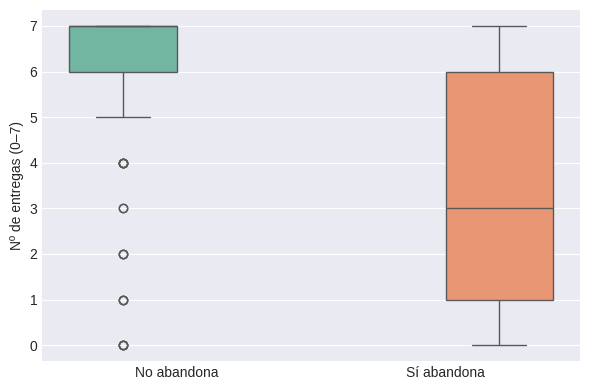

In [6]:
import seaborn as sns

NEW_PATH = "/home/carlos/Documentos/TFG/spark-workspace/data/datasets/dataset_1.1.parquet"

df_new = pd.read_parquet(NEW_PATH)
display(df_new.head())

# Visualizar distribución de entregas por clase
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_new,
    x='abandona',             # ← necesario para etiquetas
    y='num_entregas',
    hue='abandona',
    palette='Set2',
    legend=False,
    dodge=True
)
plt.xlabel("")
plt.ylabel("Nº de entregas (0–7)")
plt.xticks(ticks=[0, 1], labels=["No abandona", "Sí abandona"])  # ← etiquetas personalizadas
plt.tight_layout()
plt.show()